<a href="https://colab.research.google.com/github/zdemanche/DLforIDS/blob/main/DLforIDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
# Install additional packages if needed
!pip install imbalanced-learn seaborn matplotlib

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# For SMOTE to handle class imbalance
from imblearn.over_sampling import SMOTE

from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv("/content/drive/MyDrive/IDS4095-final/UNSW_NB15_training-set.csv", low_memory=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
# ------------------------------------------------------------
# 2. Data Preprocessing
# ------------------------------------------------------------

# Handle missing values
df.fillna(0, inplace=True)
df["attack_cat"] = df["attack_cat"].fillna("Unknown")

# For binary classification we use "label" (0 = normal, 1 = attack)
target_column = "label"
print("✅ Using '{}' for binary classification.".format(target_column))

# Convert all categorical columns to numeric
label_encoder = LabelEncoder()
for col in df.select_dtypes(include=['object']).columns:
    df[col] = label_encoder.fit_transform(df[col].astype(str))

# Define features X and target y
X = df.drop(columns=[target_column, "attack_cat"], errors='ignore')
y = df[target_column].astype(int)

# Scale numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Display class distribution before SMOTE
unique, counts = np.unique(y, return_counts=True)
print("Class distribution (raw):", dict(zip(unique, counts)))

✅ Using 'label' for binary classification.
Class distribution (raw): {0: 37000, 1: 45332}


In [29]:
# ------------------------------------------------------------
# 3. Train-Test Split and SMOTE Oversampling
# ------------------------------------------------------------

# Split data (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y,
                                                    test_size=0.2,
                                                    random_state=42)
print("Training set shape before SMOTE:", X_train.shape)
print("Target distribution before SMOTE:", np.unique(y_train, return_counts=True))

# Apply SMOTE on the training data to handle class imbalance
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
print("Training set shape after SMOTE:", X_train_res.shape)
print("Target distribution after SMOTE:", np.unique(y_train_res, return_counts=True))

Training set shape before SMOTE: (65865, 43)
Target distribution before SMOTE: (array([0, 1]), array([29582, 36283]))
Training set shape after SMOTE: (72566, 43)
Target distribution after SMOTE: (array([0, 1]), array([36283, 36283]))


In [30]:
# ------------------------------------------------------------
# 4. Build and Compile the Model
# ------------------------------------------------------------

model = Sequential()

# First layer
model.add(Dense(128, input_shape=(X_train_res.shape[1],)))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.5))

# Second layer
model.add(Dense(64))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.3))

# Third layer
model.add(Dense(32))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.2))

# Output layer for binary classification with sigmoid activation
model.add(Dense(1, activation='sigmoid'))

# Use an Adam optimizer with a lower learning rate
optimizer = Adam(learning_rate=0.00005)

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/5
567/567 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.6397 - loss: 0.6526 - val_accuracy: 0.8087 - val_loss: 0.4412
Epoch 2/5
567/567 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7971 - loss: 0.4590 - val_accuracy: 0.8604 - val_loss: 0.3295
Epoch 3/5
567/567 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8467 - loss: 0.3620 - val_accuracy: 0.8806 - val_loss: 0.2627
Epoch 4/5
567/567 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8763 - loss: 0.3021 - val_accuracy: 0.9047 - val_loss: 0.2238
Epoch 5/5
567/567 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8899 - loss: 0.2694 - val_accuracy: 0.9167 - val_loss: 0.1984


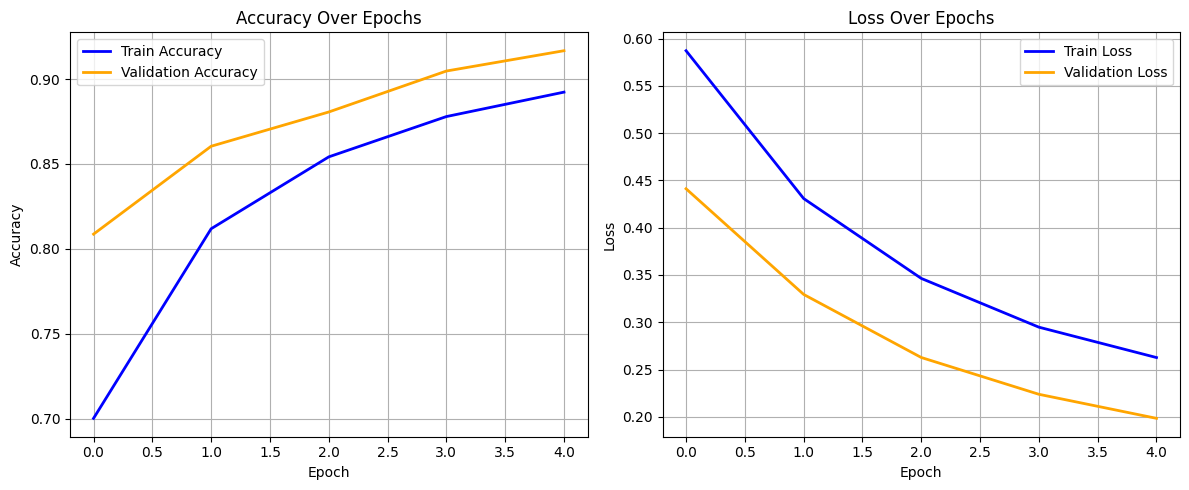

In [31]:
# ------------------------------------------------------------
# 5. Train the Model with Early Stopping
# ------------------------------------------------------------

# Set up early stopping based on validation loss
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train_res, y_train_res,
    validation_data=(X_test, y_test),
    epochs=5,
    batch_size=128,
    callbacks=[early_stop],
    verbose=1
)

# Plot training & validation accuracy and loss curves
plt.figure(figsize=(12, 5))
# Accuracy curve
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange', linewidth=2)
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
# Loss curve
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='blue', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', linewidth=2)
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

515/515 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Test Accuracy: 0.9167
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      7418
           1       0.94      0.91      0.92      9049

    accuracy                           0.92     16467
   macro avg       0.92      0.92      0.92     16467
weighted avg       0.92      0.92      0.92     16467



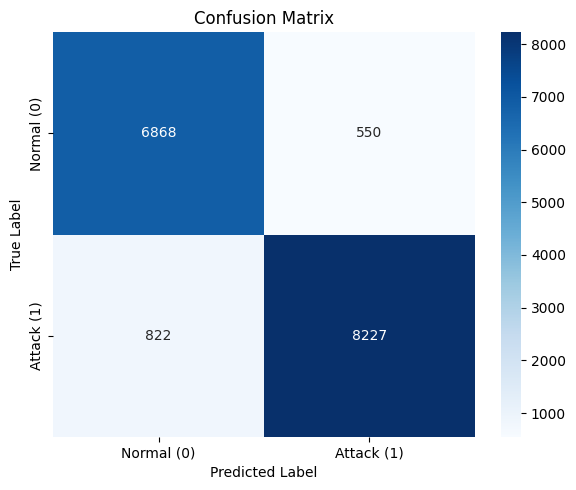

In [32]:
# ------------------------------------------------------------
# 6. Evaluate the Model
# ------------------------------------------------------------

# Predict on the test set
y_pred_prob = model.predict(X_test).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate accuracy and display the report
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal (0)', 'Attack (1)'],
            yticklabels=['Normal (0)', 'Attack (1)'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

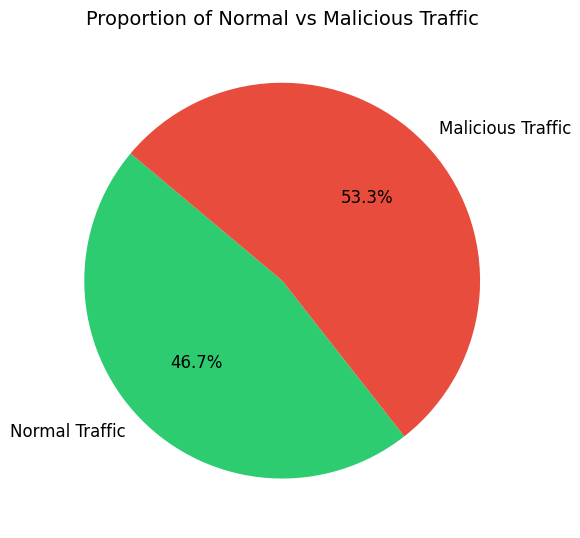

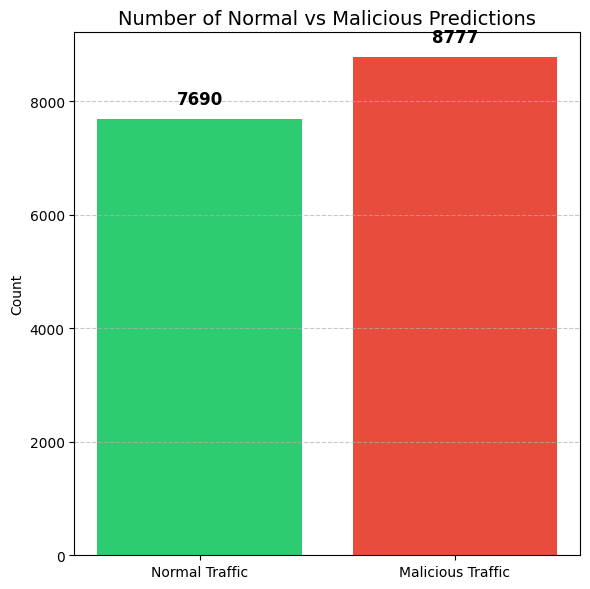

In [33]:
# ------------------------------------------------------------
# 7. Final Predictions Visualizations (Pie & Bar Charts)
# ------------------------------------------------------------

# Count predictions for each class
normal_count = (y_pred == 0).sum()
attack_count = (y_pred == 1).sum()

# Pie Chart of predictions
plt.figure(figsize=(6, 6))
plt.pie([normal_count, attack_count],
        labels=['Normal Traffic', 'Malicious Traffic'],
        colors=['#2ecc71', '#e74c3c'],
        autopct='%1.1f%%',
        startangle=140,
        textprops={'fontsize': 12})
plt.title("Proportion of Normal vs Malicious Traffic", fontsize=14)
plt.tight_layout()
plt.show()

# Bar Chart of predictions
plt.figure(figsize=(6, 6))
counts = [normal_count, attack_count]
labels = ['Normal Traffic', 'Malicious Traffic']
bars = plt.bar(labels, counts, color=['#2ecc71', '#e74c3c'])
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width()/2,
             bar.get_height() + 0.03 * max(counts),
             str(count),
             ha='center', fontsize=12, fontweight='bold')
plt.title("Number of Normal vs Malicious Predictions", fontsize=14)
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [34]:
# ------------------------------------------------------------
# 8. (Optional) Save the Trained Model
# ------------------------------------------------------------
model.save("IDS_UNSW15_Model.h5")
print("✅ Keras model saved to disk!")

✅ Keras model saved to disk!


In [50]:
import pandas as pd
import numpy as np
import time
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import load_model

# Load model
model = load_model("IDS_UNSW15_Model.h5")

# Read CSV with all headers
column_names = [
    "srcip","sport","dstip","dsport","proto","state","dur","sbytes","dbytes",
    "sttl","dttl","sloss","dloss","service","Sload","Dload","Spkts","Dpkts",
    "swin","dwin","stcpb","dtcpb","smeansz","dmeansz","trans_depth","res_bdy_len",
    "Sjit","Djit","Stime","Ltime","Sintpkt","Dintpkt","tcprtt","synack","ackdat",
    "is_sm_ips_ports","ct_state_ttl","ct_flw_http_mthd","is_ftp_login","ct_ftp_cmd",
    "ct_srv_src","ct_srv_dst","ct_dst_ltm","ct_src_dport_ltm","ct_dst_sport_ltm",
    "ct_dst_src_ltm","attack_cat","label"
]
df = pd.read_csv(
    "/content/drive/MyDrive/IDS4095-final/UNSW_NB15_testing-set.csv",
    names=column_names,
    skiprows=1,
    low_memory=False
)
df.fillna(0, inplace=True)

meta = df[["srcip", "sport", "dstip", "dsport", "proto"]]


X_df = df.drop(columns=[
    "srcip", "dstip", "attack_cat", "label", "Ltime"
], errors="ignore")
y = df["label"].astype(int).values

# Encoding columns
le = LabelEncoder()
for col in X_df.select_dtypes(include=["object"]).columns:
    X_df.loc[:, col] = le.fit_transform(X_df[col].astype(str))

# Convery numpy and scale
X_full = X_df.values.astype(float)
scaler = StandardScaler()
X_scaled_full = scaler.fit_transform(X_full)

print(f"✅ Loaded data shape: {X_scaled_full.shape}  (should be (..., 43))")

# 25 Random Samples from our model
np.random.seed(42)
demo_idx = np.random.choice(len(X_full), size=25, replace=False)
X_demo = X_scaled_full[demo_idx]
y_demo = y[demo_idx]
meta_demo = meta.iloc[demo_idx].reset_index(drop=True)

# Live IDS model demo
print("\n➡️  Quick live IDS demo — 25 real packets:\n")
for i, (x, true_lbl, row) in enumerate(
        zip(X_demo, y_demo, meta_demo.itertuples(index=False, name="Row")), 1):
    print(f"Packet {i:02d}: Analyzing packet…")
    time.sleep(0.5)

    x = x.reshape(1, -1)
    prob = model.predict(x, verbose=0)[0, 0]

    verdict = "🔴 ATTACK!" if prob > 0.5 else "🟢 normal "
    src = f"{row.srcip}:{row.sport}"
    dst = f"{row.dstip}:{row.dsport}"
    print(
        f"Packet {i:02d}: {verdict} (prob={prob:.2f}) "
        f"{src} → {dst} [proto={row.proto}] (true_label={true_lbl})\n"
    )

print("✅ Demo complete!")

✅ Loaded data shape: (175341, 43)  (should be (..., 43))

➡️  Quick live IDS demo — 25 real packets:

Packet 01: Analyzing packet…
Packet 01: 🟢 normal  (prob=0.46) 15483:2.736664 → tcp:- [proto=FIN] (true_label=0)

Packet 02: Analyzing packet…
Packet 02: 🔴 ATTACK! (prob=0.87) 133350:9e-06 → udp:dns [proto=INT] (true_label=0)

Packet 03: Analyzing packet…
Packet 03: 🟢 normal  (prob=0.29) 80486:5.788526 → tcp:- [proto=FIN] (true_label=0)

Packet 04: Analyzing packet…
Packet 04: 🟢 normal  (prob=0.17) 29973:3.849634 → tcp:- [proto=FIN] (true_label=0)

Packet 05: Analyzing packet…
Packet 05: 🔴 ATTACK! (prob=0.69) 18340:0.001052 → udp:dns [proto=CON] (true_label=0)

Packet 06: Analyzing packet…
Packet 06: 🔴 ATTACK! (prob=0.72) 170501:5e-06 → udp:dns [proto=INT] (true_label=0)

Packet 07: Analyzing packet…
Packet 07: 🔴 ATTACK! (prob=0.88) 165831:8e-06 → udp:dns [proto=INT] (true_label=0)

Packet 08: Analyzing packet…
Packet 08: 🟢 normal  (prob=0.23) 55216:1.465899 → tcp:- [proto=FIN] (true_la